In [474]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

In [475]:
import matplotlib.pyplot as plt
import seaborn as sns

In [476]:
salmon_df = pd.read_csv("data/data_salmon1.csv")
flow_df = pd.read_csv("data/flow_2023.csv")
temp_df = pd.read_csv("data/northcochiwan.csv")

display(salmon_df.head())
display(temp_df.head())
display(flow_df.head())

,tagid,watershed,earliest_detect_date,source,species
0,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt
1,989.001007,englishman,2022-05-08 06:12:40.590000,river,co
2,989.001007,englishman,2022-06-03 21:01:34.320000,river,co
3,989.001007,englishman,2022-05-29 13:57:24.490000,river,co
4,989.001007,englishman,2022-06-02 16:38:51.890000,river,co


,Unnamed: 0,TEMP,WINDCHILL,RELATIVE_HUMIDITY,WIND_SPEED,UTC_DATE,DEW_POINT_TEMP
0,0,6.4,NaN,60.0,8.0,2018-04-02T00:00:00,-0.8
1,1,5.7,NaN,68.0,10.0,2018-04-02T01:00:00,0.3
2,2,6.2,NaN,50.0,5.0,2018-04-02T02:00:00,-3.5
3,3,5.7,NaN,51.0,6.0,2018-04-02T03:00:00,-3.5
4,4,4.7,NaN,58.0,3.0,2018-04-02T04:00:00,-3.0


,STATION_NUMBER,YEAR,MONTH,FLOW1,FLOW2,FLOW3,FLOW4,FLOW5,FLOW6,FLOW7,...,FLOW22,FLOW23,FLOW24,FLOW25,FLOW26,FLOW27,FLOW28,FLOW29,FLOW30,FLOW31
0,08HA001,2018,1,24.200001,19.900000,17.400000,16.000000,28.700001,50.599998,39.099998,...,90.000000,61.299999,67.599998,57.700001,40.400002,39.099998,86.400002,356.000000,119.00,50.599998
1,08HA001,2018,2,33.599998,36.400002,42.200001,45.200001,42.000000,29.100000,23.200001,...,6.360000,6.010000,5.920000,5.880000,5.540000,5.290000,5.670000,NaN,NaN,NaN
2,08HA001,2018,3,8.450000,7.960000,7.570000,7.110000,6.700000,6.350000,6.080000,...,8.840000,9.240000,8.410000,7.620000,7.340000,8.820000,11.800000,10.300000,10.60,11.900000
3,08HA001,2018,4,10.700000,9.280000,8.120000,7.560000,12.800000,29.900000,47.700001,...,16.700001,14.800000,14.100000,15.200000,17.900000,20.600000,21.400000,18.299999,16.50,NaN
4,08HA001,2018,5,14.900000,13.600000,14.500000,15.300000,12.300000,12.600000,13.500000,...,4.290000,4.070000,3.920000,3.610000,3.240000,2.970000,2.800000,2.660000,2.72,2.490000


In [477]:
salmon_df

,tagid,watershed,earliest_detect_date,source,species
0,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt
1,989.001007,englishman,2022-05-08 06:12:40.590000,river,co
2,989.001007,englishman,2022-06-03 21:01:34.320000,river,co
3,989.001007,englishman,2022-05-29 13:57:24.490000,river,co
4,989.001007,englishman,2022-06-02 16:38:51.890000,river,co
...,...,...,...,...,...
10077,989.001045,cowichan,2023-06-14 22:57:31.540000,river,ck
10078,989.001045,cowichan,2023-06-15 01:10:00.460000,river,ck
10079,989.001045,cowichan,2023-06-15 02:57:05.460000,river,ck
10080,989.001045,cowichan,2023-06-15 11:34:58.760000,river,ck


In [478]:
len(salmon_df["tagid"].unique())

10082

In [479]:
salmon_df["Date"] = pd.to_datetime(salmon_df["earliest_detect_date"].str.split(' ').str[0])
salmon_df["Time"] = pd.to_datetime(salmon_df["earliest_detect_date"].str.split(' ').str[1])
salmon_df.head(3)

/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_1185/3064011863.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  salmon_df["Time"] = pd.to_datetime(salmon_df["earliest_detect_date"].str.split(' ').str[1])


,tagid,watershed,earliest_detect_date,source,species,Date,Time
0,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt,2022-06-28,2024-05-24 18:40:58.040
1,989.001007,englishman,2022-05-08 06:12:40.590000,river,co,2022-05-08,2024-05-24 06:12:40.590
2,989.001007,englishman,2022-06-03 21:01:34.320000,river,co,2022-06-03,2024-05-24 21:01:34.320


In [480]:
salmon_df.dtypes

tagid                          float64
watershed                       object
earliest_detect_date            object
source                          object
species                         object
Date                    datetime64[ns]
Time                    datetime64[ns]
dtype: object

In [481]:
all_columns=flow_df.iloc[:,3:].columns.tolist()
flow_df_pivoted = flow_df.melt(id_vars=["STATION_NUMBER", "YEAR", "MONTH"], var_name="Day", value_name="Flow")
flow_df_pivoted["Day"] = flow_df_pivoted["Day"].str.replace("FLOW", "").astype(int)
flow_df_pivoted["Date"] = flow_df_pivoted["YEAR"].astype(str) + "-" + flow_df_pivoted["MONTH"].astype(str) + "-" + flow_df_pivoted["Day"].astype(str)
flow_df_pivoted["Date"] = pd.to_datetime(flow_df_pivoted["Date"], errors='coerce', format='mixed')
flow_df_pivoted = flow_df_pivoted.dropna(subset=["Date"]).sort_values(by="Date")
flow_df_pivoted

,STATION_NUMBER,YEAR,MONTH,Day,Flow,Date
0,08HA001,2018,1,1,24.200001,2018-01-01
73,08HA003,2018,1,1,17.200001,2018-01-01
145,08HA001,2018,1,2,19.900000,2018-01-02
218,08HA003,2018,1,2,12.700000,2018-01-02
290,08HA001,2018,1,3,17.400000,2018-01-03
...,...,...,...,...,...,...
3842,08HA001,2024,1,27,NaN,2024-01-27
3987,08HA001,2024,1,28,NaN,2024-01-28
4132,08HA001,2024,1,29,NaN,2024-01-29
4277,08HA001,2024,1,30,NaN,2024-01-30


In [482]:
temp_df["UTC_DATE"] = pd.to_datetime(temp_df["UTC_DATE"])
temp_df['Year'] = temp_df['UTC_DATE'].dt.year
temp_df['Month'] = temp_df['UTC_DATE'].dt.month
temp_df['Day'] = temp_df['UTC_DATE'].dt.day
temp_df['Time'] = temp_df['UTC_DATE'].dt.time
temp_df['Date'] = pd.to_datetime(temp_df['Year'].astype(str) + '-' + temp_df['Month'].astype(str) + '-' + temp_df['Day'].astype(str), errors='coerce')
temp_df = temp_df.dropna(subset=["Date"])
temp_df

,Unnamed: 0,TEMP,WINDCHILL,RELATIVE_HUMIDITY,WIND_SPEED,UTC_DATE,DEW_POINT_TEMP,Year,Month,Day,Time,Date
0,0,6.4,NaN,60.0,8.0,2018-04-02 00:00:00,-0.8,2018,4,2,00:00:00,2018-04-02
1,1,5.7,NaN,68.0,10.0,2018-04-02 01:00:00,0.3,2018,4,2,01:00:00,2018-04-02
2,2,6.2,NaN,50.0,5.0,2018-04-02 02:00:00,-3.5,2018,4,2,02:00:00,2018-04-02
3,3,5.7,NaN,51.0,6.0,2018-04-02 03:00:00,-3.5,2018,4,2,03:00:00,2018-04-02
4,4,4.7,NaN,58.0,3.0,2018-04-02 04:00:00,-3.0,2018,4,2,04:00:00,2018-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...
53368,3368,17.5,NaN,56.0,2.0,2024-05-14 02:00:00,8.7,2024,5,14,02:00:00,2024-05-14
53369,3369,15.2,NaN,68.0,3.0,2024-05-14 03:00:00,9.3,2024,5,14,03:00:00,2024-05-14
53370,3370,13.2,NaN,78.0,1.0,2024-05-14 04:00:00,9.5,2024,5,14,04:00:00,2024-05-14
53371,3371,11.8,NaN,83.0,0.0,2024-05-14 05:00:00,9.0,2024,5,14,05:00:00,2024-05-14


In [483]:
# Filter out
# filter_df = pd.read_csv("data/advanced_field_data.csv")
# filter_df

In [484]:
# filter_list = filter_df["tag_id_long"].unique().tolist()
# salmon_df = salmon_df[salmon_df["tagid"].isin(filter_list)]
# salmon_df.shape

In [485]:
df = salmon_df.merge(temp_df, on="Date")
df

,tagid,watershed,earliest_detect_date,source,species,Date,Time_x,Unnamed: 0,TEMP,WINDCHILL,RELATIVE_HUMIDITY,WIND_SPEED,UTC_DATE,DEW_POINT_TEMP,Year,Month,Day,Time_y
0,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt,2022-06-28,2024-05-24 18:40:58.040,6922,31.5,NaN,32.0,4.0,2022-06-28 00:00:00,12.7,2022,6,28,00:00:00
1,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt,2022-06-28,2024-05-24 18:40:58.040,6923,29.9,NaN,30.0,6.0,2022-06-28 01:00:00,10.2,2022,6,28,01:00:00
2,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt,2022-06-28,2024-05-24 18:40:58.040,6924,29.0,NaN,37.0,9.0,2022-06-28 02:00:00,12.8,2022,6,28,02:00:00
3,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt,2022-06-28,2024-05-24 18:40:58.040,6925,28.5,NaN,35.0,5.0,2022-06-28 03:00:00,11.7,2022,6,28,03:00:00
4,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt,2022-06-28,2024-05-24 18:40:58.040,6926,26.8,NaN,33.0,8.0,2022-06-28 04:00:00,9.3,2022,6,28,04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241951,989.001045,cowichan,2023-06-14 23:41:32.740000,river,ck,2023-06-14,2024-05-24 23:41:32.740,5353,15.8,NaN,56.0,6.0,2023-06-14 19:00:00,7.0,2023,6,14,19:00:00
241952,989.001045,cowichan,2023-06-14 23:41:32.740000,river,ck,2023-06-14,2024-05-24 23:41:32.740,5354,16.6,NaN,53.0,5.0,2023-06-14 20:00:00,7.1,2023,6,14,20:00:00
241953,989.001045,cowichan,2023-06-14 23:41:32.740000,river,ck,2023-06-14,2024-05-24 23:41:32.740,5355,17.1,NaN,52.0,4.0,2023-06-14 21:00:00,7.1,2023,6,14,21:00:00
241954,989.001045,cowichan,2023-06-14 23:41:32.740000,river,ck,2023-06-14,2024-05-24 23:41:32.740,5356,18.4,NaN,50.0,6.0,2023-06-14 22:00:00,7.8,2023,6,14,22:00:00


In [486]:
df = df.merge(flow_df_pivoted, on="Date")
df

,tagid,watershed,earliest_detect_date,source,species,Date,Time_x,Unnamed: 0,TEMP,WINDCHILL,...,DEW_POINT_TEMP,Year,Month,Day_x,Time_y,STATION_NUMBER,YEAR,MONTH,Day_y,Flow
0,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt,2022-06-28,2024-05-24 18:40:58.040,6922,31.5,NaN,...,12.7,2022,6,28,00:00:00,08HA003,2022,6,28,1.730
1,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt,2022-06-28,2024-05-24 18:40:58.040,6922,31.5,NaN,...,12.7,2022,6,28,00:00:00,08HA001,2022,6,28,5.140
2,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt,2022-06-28,2024-05-24 18:40:58.040,6923,29.9,NaN,...,10.2,2022,6,28,01:00:00,08HA003,2022,6,28,1.730
3,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt,2022-06-28,2024-05-24 18:40:58.040,6923,29.9,NaN,...,10.2,2022,6,28,01:00:00,08HA001,2022,6,28,5.140
4,989.001007,englishman,2022-06-28 18:40:58.040000,river,rbt,2022-06-28,2024-05-24 18:40:58.040,6924,29.0,NaN,...,12.8,2022,6,28,02:00:00,08HA003,2022,6,28,1.730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483907,989.001045,cowichan,2023-06-14 23:41:32.740000,river,ck,2023-06-14,2024-05-24 23:41:32.740,5355,17.1,NaN,...,7.1,2023,6,14,21:00:00,08HA001,2023,6,14,1.590
483908,989.001045,cowichan,2023-06-14 23:41:32.740000,river,ck,2023-06-14,2024-05-24 23:41:32.740,5356,18.4,NaN,...,7.8,2023,6,14,22:00:00,08HA003,2023,6,14,0.737
483909,989.001045,cowichan,2023-06-14 23:41:32.740000,river,ck,2023-06-14,2024-05-24 23:41:32.740,5356,18.4,NaN,...,7.8,2023,6,14,22:00:00,08HA001,2023,6,14,1.590
483910,989.001045,cowichan,2023-06-14 23:41:32.740000,river,ck,2023-06-14,2024-05-24 23:41:32.740,5357,18.2,NaN,...,8.3,2023,6,14,23:00:00,08HA003,2023,6,14,0.737


In [487]:
print(df.columns)

Index(['tagid', 'watershed', 'earliest_detect_date', 'source', 'species',
       'Date', 'Time_x', 'Unnamed: 0', 'TEMP', 'WINDCHILL',
       'RELATIVE_HUMIDITY', 'WIND_SPEED', 'UTC_DATE', 'DEW_POINT_TEMP', 'Year',
       'Month', 'Day_x', 'Time_y', 'STATION_NUMBER', 'YEAR', 'MONTH', 'Day_y',
       'Flow'],
      dtype='object')


In [488]:
columns_keep = ["tagid", "watershed", "species", "Date", "TEMP", "YEAR", "MONTH", "Day_y",
                "WIND_SPEED", "RELATIVE_HUMIDITY", "DEW_POINT_TEMP", "STATION_NUMBER",
                "Flow"]
# df = df.rename(columns={"Day_y":"Day"})
df = df[columns_keep]
df = df[df["YEAR"] == 2023]
df["Date"] = pd.to_datetime(df["Date"])
print(df.dtypes)

tagid                       float64
watershed                    object
species                      object
Date                 datetime64[ns]
TEMP                        float64
YEAR                          int64
MONTH                         int64
Day_y                         int64
WIND_SPEED                  float64
RELATIVE_HUMIDITY           float64
DEW_POINT_TEMP              float64
STATION_NUMBER               object
Flow                        float64
dtype: object


In [489]:
earliest_date = df.sort_values(by="Date").iloc[0:1, :]["Date"].values[0]
df["days_passed"] = (df['Date'] - earliest_date).dt.days
df

,tagid,watershed,species,Date,TEMP,YEAR,MONTH,Day_y,WIND_SPEED,RELATIVE_HUMIDITY,DEW_POINT_TEMP,STATION_NUMBER,Flow,days_passed
1392,989.001034,englishman,ct,2023-05-02,18.2,2023,5,2,8.0,41.0,4.9,08HA001,23.100,29
1393,989.001034,englishman,ct,2023-05-02,18.2,2023,5,2,8.0,41.0,4.9,08HA003,6.100,29
1394,989.001034,englishman,ct,2023-05-02,17.7,2023,5,2,4.0,43.0,5.0,08HA001,23.100,29
1395,989.001034,englishman,ct,2023-05-02,17.7,2023,5,2,4.0,43.0,5.0,08HA003,6.100,29
1396,989.001034,englishman,ct,2023-05-02,15.9,2023,5,2,5.0,55.0,6.9,08HA001,23.100,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483907,989.001045,cowichan,ck,2023-06-14,17.1,2023,6,14,4.0,52.0,7.1,08HA001,1.590,72
483908,989.001045,cowichan,ck,2023-06-14,18.4,2023,6,14,6.0,50.0,7.8,08HA003,0.737,72
483909,989.001045,cowichan,ck,2023-06-14,18.4,2023,6,14,6.0,50.0,7.8,08HA001,1.590,72
483910,989.001045,cowichan,ck,2023-06-14,18.2,2023,6,14,8.0,53.0,8.3,08HA003,0.737,72


In [490]:
# Find the index of the earliest date for each tagid
idx = df.groupby('tagid')['days_passed'].idxmin()
print(idx)

# Filter the DataFrame to keep only the entries with the earliest date for each tagid
df = df.loc[idx].reset_index(drop=True)

display(df.head(5))
print(df.shape)

tagid
989.001034      1392
989.001034      1440
989.001034      1488
989.001034      1536
989.001034      1584
               ...  
989.001045    483672
989.001045    483720
989.001045    483768
989.001045    483816
989.001045    483864
Name: days_passed, Length: 9359, dtype: int64


,tagid,watershed,species,Date,TEMP,YEAR,MONTH,Day_y,WIND_SPEED,RELATIVE_HUMIDITY,DEW_POINT_TEMP,STATION_NUMBER,Flow,days_passed
0,989.001034,englishman,ct,2023-05-02,18.2,2023,5,2,8.0,41.0,4.9,08HA001,23.100,29
1,989.001034,englishman,ct,2023-06-25,21.3,2023,6,25,4.0,51.0,10.7,08HA003,0.559,83
2,989.001034,englishman,rbt,2023-05-02,18.2,2023,5,2,8.0,41.0,4.9,08HA001,23.100,29
3,989.001034,englishman,stl,2023-05-09,15.0,2023,5,9,5.0,65.0,8.4,08HA003,3.970,36
4,989.001034,englishman,rbt,2023-06-14,19.1,2023,6,14,7.0,56.0,10.2,08HA003,0.737,72


(9359, 14)


In [491]:
keep_columns = ["tagid", "watershed", "species", "TEMP", "WIND_SPEED", "RELATIVE_HUMIDITY", "DEW_POINT_TEMP", "Flow", "days_passed"]
df = df[keep_columns]
df

,tagid,watershed,species,TEMP,WIND_SPEED,RELATIVE_HUMIDITY,DEW_POINT_TEMP,Flow,days_passed
0,989.001034,englishman,ct,18.2,8.0,41.0,4.9,23.100,29
1,989.001034,englishman,ct,21.3,4.0,51.0,10.7,0.559,83
2,989.001034,englishman,rbt,18.2,8.0,41.0,4.9,23.100,29
3,989.001034,englishman,stl,15.0,5.0,65.0,8.4,3.970,36
4,989.001034,englishman,rbt,19.1,7.0,56.0,10.2,0.737,72
...,...,...,...,...,...,...,...,...,...
9354,989.001045,cowichan,ck,19.1,7.0,56.0,10.2,0.737,72
9355,989.001045,cowichan,ck,18.1,10.0,54.0,8.6,0.706,73
9356,989.001045,cowichan,ck,18.1,10.0,54.0,8.6,0.706,73
9357,989.001045,cowichan,ck,18.1,10.0,54.0,8.6,0.706,73


In [492]:
numeric_features = ["WIND_SPEED", "RELATIVE_HUMIDITY", "DEW_POINT_TEMP", "Flow"]
categorical_features = ["watershed", "species"]

In [493]:
def lag_df(df, numeric_cols, lag=1):
    lagged_df = pd.DataFrame()
    for col in numeric_cols:
        for i in range(lag + 1):
            lagged_df[f'{col}_t-{i}'] = df[col].shift(i)
    return lagged_df.dropna()

SEQUENCE_LENGTH = 5
lag_df_applied = lag_df(df, numeric_features, lag=SEQUENCE_LENGTH)
lag_df_applied

,WIND_SPEED_t-0,WIND_SPEED_t-1,WIND_SPEED_t-2,WIND_SPEED_t-3,WIND_SPEED_t-4,WIND_SPEED_t-5,RELATIVE_HUMIDITY_t-0,RELATIVE_HUMIDITY_t-1,RELATIVE_HUMIDITY_t-2,RELATIVE_HUMIDITY_t-3,...,DEW_POINT_TEMP_t-2,DEW_POINT_TEMP_t-3,DEW_POINT_TEMP_t-4,DEW_POINT_TEMP_t-5,Flow_t-0,Flow_t-1,Flow_t-2,Flow_t-3,Flow_t-4,Flow_t-5
5,5.0,7.0,5.0,8.0,4.0,8.0,65.0,56.0,65.0,41.0,...,8.4,4.9,10.7,4.9,3.970,0.737,3.970,23.100,0.559,23.100
6,8.0,5.0,7.0,5.0,8.0,4.0,41.0,65.0,56.0,65.0,...,10.2,8.4,4.9,10.7,23.100,3.970,0.737,3.970,23.100,0.559
7,9.0,8.0,5.0,7.0,5.0,8.0,39.0,41.0,65.0,56.0,...,8.4,10.2,8.4,4.9,2.300,23.100,3.970,0.737,3.970,23.100
8,7.0,9.0,8.0,5.0,7.0,5.0,22.0,39.0,41.0,65.0,...,4.9,8.4,10.2,8.4,0.687,2.300,23.100,3.970,0.737,3.970
9,4.0,7.0,9.0,8.0,5.0,7.0,53.0,22.0,39.0,41.0,...,7.9,4.9,8.4,10.2,3.780,0.687,2.300,23.100,3.970,0.737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9354,7.0,10.0,7.0,10.0,7.0,10.0,56.0,54.0,56.0,54.0,...,10.2,8.6,10.2,8.6,0.737,0.706,0.737,0.706,0.737,0.706
9355,10.0,7.0,10.0,7.0,10.0,7.0,54.0,56.0,54.0,56.0,...,8.6,10.2,8.6,10.2,0.706,0.737,0.706,0.737,0.706,0.737
9356,10.0,10.0,7.0,10.0,7.0,10.0,54.0,54.0,56.0,54.0,...,10.2,8.6,10.2,8.6,0.706,0.706,0.737,0.706,0.737,0.706
9357,10.0,10.0,10.0,7.0,10.0,7.0,54.0,54.0,54.0,56.0,...,8.6,10.2,8.6,10.2,0.706,0.706,0.706,0.737,0.706,0.737


In [494]:
keep_columns_ = categorical_features + ["days_passed"]
df = pd.concat([df[keep_columns_], lag_df_applied], axis=1)
df

,watershed,species,days_passed,WIND_SPEED_t-0,WIND_SPEED_t-1,WIND_SPEED_t-2,WIND_SPEED_t-3,WIND_SPEED_t-4,WIND_SPEED_t-5,RELATIVE_HUMIDITY_t-0,...,DEW_POINT_TEMP_t-2,DEW_POINT_TEMP_t-3,DEW_POINT_TEMP_t-4,DEW_POINT_TEMP_t-5,Flow_t-0,Flow_t-1,Flow_t-2,Flow_t-3,Flow_t-4,Flow_t-5
0,englishman,ct,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,englishman,ct,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,englishman,rbt,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,englishman,stl,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,englishman,rbt,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9354,cowichan,ck,72,7.0,10.0,7.0,10.0,7.0,10.0,56.0,...,10.2,8.6,10.2,8.6,0.737,0.706,0.737,0.706,0.737,0.706
9355,cowichan,ck,73,10.0,7.0,10.0,7.0,10.0,7.0,54.0,...,8.6,10.2,8.6,10.2,0.706,0.737,0.706,0.737,0.706,0.737
9356,cowichan,ck,73,10.0,10.0,7.0,10.0,7.0,10.0,54.0,...,10.2,8.6,10.2,8.6,0.706,0.706,0.737,0.706,0.737,0.706
9357,cowichan,ck,73,10.0,10.0,10.0,7.0,10.0,7.0,54.0,...,8.6,10.2,8.6,10.2,0.706,0.706,0.706,0.737,0.706,0.737


In [495]:
df.columns

Index(['watershed', 'species', 'days_passed', 'WIND_SPEED_t-0',
       'WIND_SPEED_t-1', 'WIND_SPEED_t-2', 'WIND_SPEED_t-3', 'WIND_SPEED_t-4',
       'WIND_SPEED_t-5', 'RELATIVE_HUMIDITY_t-0', 'RELATIVE_HUMIDITY_t-1',
       'RELATIVE_HUMIDITY_t-2', 'RELATIVE_HUMIDITY_t-3',
       'RELATIVE_HUMIDITY_t-4', 'RELATIVE_HUMIDITY_t-5', 'DEW_POINT_TEMP_t-0',
       'DEW_POINT_TEMP_t-1', 'DEW_POINT_TEMP_t-2', 'DEW_POINT_TEMP_t-3',
       'DEW_POINT_TEMP_t-4', 'DEW_POINT_TEMP_t-5', 'Flow_t-0', 'Flow_t-1',
       'Flow_t-2', 'Flow_t-3', 'Flow_t-4', 'Flow_t-5'],
      dtype='object')

In [496]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df.head()

X_train = train_df.drop(columns=["days_passed"])
y_train = train_df["days_passed"]

X_test = test_df.drop(columns=["days_passed"])
y_test = test_df["days_passed"]

In [497]:
# Establish pipeline
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

numeric_lag_features = lag_df_applied.columns.tolist()

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_lag_features),
    (categorical_transformer, categorical_features),
)



In [498]:
preprocessor.fit(X_train)
preprocessor.named_transformers_

{'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='missing', strategy='constant')),
                 ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])}

In [499]:
model = LinearRegression()
lr_pipe = make_pipeline(preprocessor, model)
lr_pipe.fit(X_train, y_train)
scores = cross_validate(lr_pipe, X_train, y_train, return_train_score=True)
print(f"Mean test score: {pd.DataFrame(scores)['test_score'].mean()}")
print(f"Mean training score: {pd.DataFrame(scores)['train_score'].mean()}")
pd.DataFrame(scores)

Mean test score: 0.812467479008841
Mean training score: 0.817604959663519


,fit_time,score_time,test_score,train_score
0,0.014926,0.002544,0.806856,0.818676
1,0.014246,0.002113,0.818077,0.816050
2,0.013470,0.001951,0.806551,0.819316
3,0.013634,0.002095,0.830791,0.813168
4,0.016876,0.001939,0.800063,0.820815


In [500]:
# test_val = pd.DataFrame(["englishman", "ct", 18.7, 9.0, 43.0, 6.7, 28.0]).T
# test_val.columns = X_train.columns
# display(test_val)
# lr_pipe.predict(test_val)

In [501]:
pred_vals = lr_pipe.predict(X_test)
rounded_vals = list(map(round, pred_vals))
X_pred_df = X_test.copy()
X_pred_df["days_passed"] = y_test
X_pred_df["pred_days_passed"] = rounded_vals

X_pred_df

,watershed,species,WIND_SPEED_t-0,WIND_SPEED_t-1,WIND_SPEED_t-2,WIND_SPEED_t-3,WIND_SPEED_t-4,WIND_SPEED_t-5,RELATIVE_HUMIDITY_t-0,RELATIVE_HUMIDITY_t-1,...,DEW_POINT_TEMP_t-4,DEW_POINT_TEMP_t-5,Flow_t-0,Flow_t-1,Flow_t-2,Flow_t-3,Flow_t-4,Flow_t-5,days_passed,pred_days_passed
5240,nanaimo,ck,4.0,4.0,4.0,4.0,4.0,4.0,42.0,42.0,...,10.7,10.7,1.66,1.660,1.660,1.660,1.660,1.660,67,70
7652,cowichan,ck,4.0,4.0,4.0,4.0,4.0,6.0,57.0,57.0,...,7.0,9.2,5.28,5.280,5.280,5.280,5.280,1.480,51,51
8961,cowichan,co,4.0,7.0,7.0,8.0,8.0,7.0,47.0,17.0,...,6.0,1.8,1.00,0.742,0.803,3.410,2.390,0.742,59,51
2095,goldstream,co,7.0,4.0,3.0,3.0,3.0,7.0,21.0,19.0,...,14.1,7.5,15.00,2.500,2.010,2.010,2.010,15.000,43,43
3357,goldstream,co,5.0,7.0,6.0,12.0,6.0,3.0,47.0,21.0,...,13.3,14.1,10.70,15.000,1.730,6.650,1.610,2.010,46,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,englishman,stl,6.0,4.0,6.0,5.0,8.0,4.0,61.0,87.0,...,4.9,8.3,4.30,5.370,1.730,0.692,23.100,3.780,35,44
889,nanaimo,ck,3.0,3.0,5.0,3.0,5.0,7.0,80.0,80.0,...,12.8,11.8,2.13,2.130,0.888,2.130,0.915,1.140,68,68
7040,cowichan,ck,4.0,8.0,8.0,4.0,8.0,6.0,57.0,51.0,...,9.7,7.4,5.28,4.870,3.130,5.280,4.870,4.300,51,56
1300,puntledge,ck,4.0,4.0,3.0,4.0,4.0,4.0,22.0,42.0,...,6.3,10.7,1.76,1.660,2.130,1.660,1.760,1.660,66,67


In [502]:
rounded_vals = list(map(round, pred_vals))

In [503]:
pd.Timestamp(earliest_date) + timedelta(days=32)

Timestamp('2023-05-05 00:00:00')

In [504]:
def change_to_date(row, ref_date=earliest_date):
      row["detection_date"] = pd.Timestamp(ref_date) + timedelta(days=int(row["days_passed"]))
      row["pred_detection_date"] = pd.Timestamp(ref_date) + timedelta(days=int(row["pred_days_passed"]))
      return row

In [505]:
def find_quantile(df, column="pred_days_passed"):
      df = df.sort_values(by=column)
      first_quantile = df[column].quantile(0.25)
      percentile_25_date = pd.Timestamp(earliest_date) + timedelta(days=first_quantile)
      third_quantile = df[column].quantile(0.75)
      percentile_75_date = pd.Timestamp(earliest_date) + timedelta(days=third_quantile)
      return percentile_25_date, percentile_75_date

In [506]:
first_quantile, third_quantile = find_quantile(X_pred_df)
print(first_quantile)
print(third_quantile)

first_quantile_real, third_quantile_real = find_quantile(X_pred_df, "days_passed")
print(first_quantile_real)
print(third_quantile_real)

2023-05-19 00:00:00
2023-06-10 00:00:00
2023-05-18 00:00:00
2023-06-09 00:00:00


In [507]:
X_pred_df = X_pred_df.apply(lambda row: change_to_date(row), axis=1)
X_pred_df

,watershed,species,WIND_SPEED_t-0,WIND_SPEED_t-1,WIND_SPEED_t-2,WIND_SPEED_t-3,WIND_SPEED_t-4,WIND_SPEED_t-5,RELATIVE_HUMIDITY_t-0,RELATIVE_HUMIDITY_t-1,...,Flow_t-0,Flow_t-1,Flow_t-2,Flow_t-3,Flow_t-4,Flow_t-5,days_passed,pred_days_passed,detection_date,pred_detection_date
5240,nanaimo,ck,4.0,4.0,4.0,4.0,4.0,4.0,42.0,42.0,...,1.66,1.660,1.660,1.660,1.660,1.660,67,70,2023-06-09,2023-06-12
7652,cowichan,ck,4.0,4.0,4.0,4.0,4.0,6.0,57.0,57.0,...,5.28,5.280,5.280,5.280,5.280,1.480,51,51,2023-05-24,2023-05-24
8961,cowichan,co,4.0,7.0,7.0,8.0,8.0,7.0,47.0,17.0,...,1.00,0.742,0.803,3.410,2.390,0.742,59,51,2023-06-01,2023-05-24
2095,goldstream,co,7.0,4.0,3.0,3.0,3.0,7.0,21.0,19.0,...,15.00,2.500,2.010,2.010,2.010,15.000,43,43,2023-05-16,2023-05-16
3357,goldstream,co,5.0,7.0,6.0,12.0,6.0,3.0,47.0,21.0,...,10.70,15.000,1.730,6.650,1.610,2.010,46,50,2023-05-19,2023-05-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,englishman,stl,6.0,4.0,6.0,5.0,8.0,4.0,61.0,87.0,...,4.30,5.370,1.730,0.692,23.100,3.780,35,44,2023-05-08,2023-05-17
889,nanaimo,ck,3.0,3.0,5.0,3.0,5.0,7.0,80.0,80.0,...,2.13,2.130,0.888,2.130,0.915,1.140,68,68,2023-06-10,2023-06-10
7040,cowichan,ck,4.0,8.0,8.0,4.0,8.0,6.0,57.0,51.0,...,5.28,4.870,3.130,5.280,4.870,4.300,51,56,2023-05-24,2023-05-29
1300,puntledge,ck,4.0,4.0,3.0,4.0,4.0,4.0,22.0,42.0,...,1.76,1.660,2.130,1.660,1.760,1.660,66,67,2023-06-08,2023-06-09


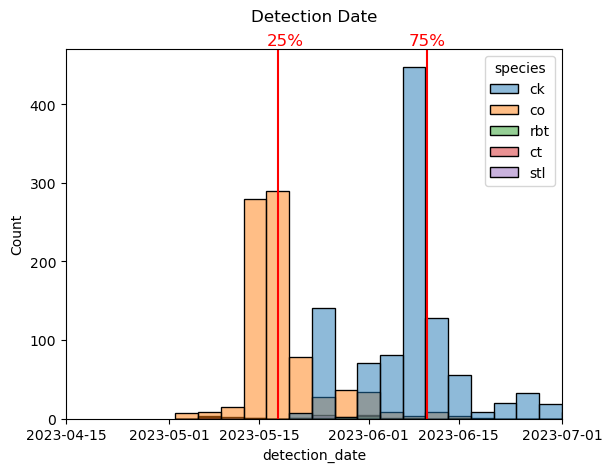

In [508]:
ax = sns.histplot(data=X_pred_df, x="detection_date", hue="species")
ax.axvline(x=first_quantile_real, color="red")
ax.axvline(x=third_quantile, color="red")
ax.annotate(f'25%', xy=(first_quantile, ax.get_ylim()[1]), xytext=(first_quantile, ax.get_ylim()[1] +5),
            fontsize=12, color='red', ha='center')
ax.annotate('75%', xy=(third_quantile, ax.get_ylim()[1]), xytext=(third_quantile, ax.get_ylim()[1] + 5),
            fontsize=12, color='red', ha='center')
plt.title("Detection Date", pad=20)
plt.xlim(pd.Timestamp('2023-04-15'), pd.Timestamp('2023-07-01'))
plt.show()

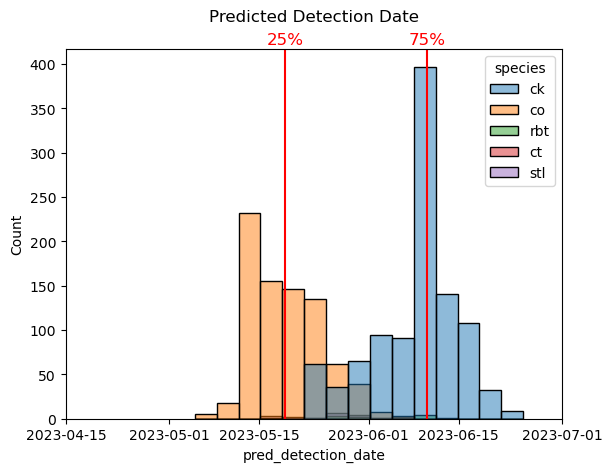

In [509]:
ax = sns.histplot(data=X_pred_df, x="pred_detection_date", hue="species")
ax.axvline(x=first_quantile, color="red")
ax.axvline(x=third_quantile, color="red")
ax.annotate('25%', xy=(first_quantile, ax.get_ylim()[1]), xytext=(first_quantile, ax.get_ylim()[1] + 5),
            fontsize=12, color='red', ha='center')
ax.annotate('75%', xy=(third_quantile, ax.get_ylim()[1]), xytext=(third_quantile, ax.get_ylim()[1] + 5),
            fontsize=12, color='red', ha='center')
plt.title("Predicted Detection Date", pad=20)
plt.xlim(pd.Timestamp('2023-04-15'), pd.Timestamp('2023-07-01'))
plt.show()